In [1]:
import json
import numpy as np
import pandas as pd
# from src import *

In [2]:
# Set path to data
path = '../data/raw/CDSA_.xlsx'

# Import data
cdsa = pd.read_excel(path, sheet_name='CDSA')
labs = pd.read_excel(path, sheet_name='repeat2')
cnss = pd.read_excel(path, sheet_name='repeat1_001')
cvss = pd.read_excel(path, sheet_name='repeat1_002')
urss = pd.read_excel(path, sheet_name='repeat1_003')
lrss = pd.read_excel(path, sheet_name='repeat1_004')
gits = pd.read_excel(path, sheet_name='repeat1_005')
guss = pd.read_excel(path, sheet_name='repeat1_006')
msss = pd.read_excel(path, sheet_name='repeat1_007')
skns = pd.read_excel(path, sheet_name='repeat1_008')
spss = pd.read_excel(path, sheet_name='repeat1_009')
oths = pd.read_excel(path, sheet_name='repeat1_010')

# Import columns from json file
with open('../data/dictionaries/columns.json') as f:
    columns, multiple_entry_cols, diagnosis = json.load(f).values()

In [3]:
for k, v in columns.items():
    if k in multiple_entry_cols:
        multiple_entry_cols[v] = multiple_entry_cols.pop(k)
        
multiple_entry_cols

{'gen_signs': ['Swelling of limbs (Oedema)',
  'Night sweats',
  'Skin being cold or clammy',
  'Skin turning pale',
  'Skin turning bluish color (cyanosis)']}

In [4]:
def select_columns(df: pd.DataFrame,
                          columns: dict,
                          rename: bool = True) -> pd.DataFrame:
    """
    Filter columns of a dataframe based on the keys of a dictionary.
    """
    df_ = df[df.columns.intersection(columns.keys())]
    if rename:
        df_ = df_.rename(columns=columns)
    return df_

cdsa_ = select_columns(cdsa, columns)
labs_ = select_columns(labs, columns)
cnss_ = select_columns(cnss, columns)
cvss_ = select_columns(cvss, columns)
urss_ = select_columns(urss, columns)
lrss_ = select_columns(lrss, columns)
gits_ = select_columns(gits, columns)
guss_ = select_columns(guss, columns)
msss_ = select_columns(msss, columns)
skns_ = select_columns(skns, columns)
spss_ = select_columns(spss, columns)
oths_ = select_columns(oths, columns)

In [5]:
# Merge dataframes
ss = pd.merge(cnss_, cvss_, on=cnss_.columns.intersection(cvss_.columns).tolist(), how='outer')
ss = pd.merge(ss, urss_, on=ss.columns.intersection(urss_.columns).tolist(), how='outer')
ss = pd.merge(ss, lrss_, on=ss.columns.intersection(lrss_.columns).tolist(), how='outer')
ss = pd.merge(ss, gits_, on=ss.columns.intersection(gits_.columns).tolist(), how='outer')
ss = pd.merge(ss, guss_, on=ss.columns.intersection(guss_.columns).tolist(), how='outer')
ss = pd.merge(ss, msss_, on=ss.columns.intersection(msss_.columns).tolist(), how='outer')
ss = pd.merge(ss, skns_, on=ss.columns.intersection(skns_.columns).tolist(), how='outer')
ss = pd.merge(ss, spss_, on=ss.columns.intersection(spss_.columns).tolist(), how='outer')
ss = pd.merge(ss, oths_, on=ss.columns.intersection(oths_.columns).tolist(), how='outer')
ss = pd.merge(ss, labs_, on=ss.columns.intersection(labs_.columns).tolist(), how='outer')
df = pd.merge(cdsa_, ss, on=cdsa_.columns.intersection(ss.columns).tolist(), how='outer')

df.drop_duplicates(ignore_index=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             3199 non-null   object 
 1   patient_id         3769 non-null   object 
 2   age                3766 non-null   float64
 3   sex                3751 non-null   object 
 4   temperature        2961 non-null   float64
 5   triage_            302 non-null    object 
 6   blood_pressure     1026 non-null   object 
 7   weight             2958 non-null   float64
 8   failure_to_thrive  1247 non-null   object 
 9   height             2585 non-null   float64
 10  stunting           1066 non-null   object 
 11  spo2               1973 non-null   float64
 12  chills             2771 non-null   object 
 13  muac               972 non-null    object 
 14  gen_signs          557 non-null    object 
 15  lab_investigation  3759 non-null   object 
 16  diagnosis          703

In [7]:
def split_cells(df: pd.DataFrame,
                column: str,
                uv: list = None,
                sep: str = "&") -> pd.DataFrame:
    """
    Split the cells of a column into multiple rows
    """
    if uv is None:
        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)
    else:
        if not isinstance(uv, list):
            uv = list(uv)
        for i in uv:
            df[column] = df[column].str.replace(i, sep + i + sep)
        df[column] = df[column].str.replace(sep + r"\s+", sep, regex=True)
        df[column] = df[column].str.replace(sep + r"$", "", regex=True)
        df[column] = df[column].str.replace(r"^" + sep, "", regex=True)
        df[column] = df[column].str.replace(sep + sep, sep)

        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)

        df[column] = df[column].str.strip()

    return df

# Split cells
for k, v in multiple_entry_cols.items():
    df = split_cells(df, k, v)
    
# Drop duplicates in every column except duration
df.drop_duplicates(subset=df.columns.difference(["duration"]), inplace=True)

# Repopulate the cdsa columns
for col in df.columns.intersection(cdsa_.columns):
    df[col] = df.groupby("_uuid")[col].transform("first")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11581 entries, 0 to 11580
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             10078 non-null  object 
 1   patient_id         11567 non-null  object 
 2   age                11558 non-null  float64
 3   sex                11486 non-null  object 
 4   temperature        9044 non-null   float64
 5   triage_            749 non-null    object 
 6   blood_pressure     3579 non-null   object 
 7   weight             9198 non-null   float64
 8   failure_to_thrive  3123 non-null   object 
 9   height             8123 non-null   float64
 10  stunting           2601 non-null   object 
 11  spo2               5608 non-null   float64
 12  chills             7805 non-null   object 
 13  muac               2745 non-null   object 
 14  gen_signs          2173 non-null   object 
 15  lab_investigation  11561 non-null  object 
 16  diagnosis          114

In [8]:
# Construct triage_signs
df["fever"] = np.where(df["temperature"] > 37.5, "Fever", np.nan)
df["failure_to_thrive"] = np.where(df["failure_to_thrive"] == "Yes", "Failure to thrive", np.nan)
df["stunting"] = np.where(df["stunting"] == "Yes", "Stunting", np.nan)
df["chills"] = np.where(df["chills"] == "Yes", "Chills", np.nan)

triage_cols = ["triage_", "fever", "failure_to_thrive", "stunting", "chills"]

df = pd.melt(df, id_vars=[i for i in df.columns if i not in triage_cols],
             value_vars=triage_cols, var_name="trg", value_name="trg_signs").drop("trg", axis=1).drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27344 entries, 0 to 57904
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             23809 non-null  object 
 1   patient_id         27312 non-null  object 
 2   age                27292 non-null  float64
 3   sex                27118 non-null  object 
 4   temperature        21985 non-null  float64
 5   blood_pressure     8339 non-null   object 
 6   weight             22205 non-null  float64
 7   height             19573 non-null  float64
 8   spo2               13892 non-null  float64
 9   muac               7325 non-null   object 
 10  gen_signs          5134 non-null   object 
 11  lab_investigation  27304 non-null  object 
 12  diagnosis          27166 non-null  object 
 13  _uuid              27344 non-null  object 
 14  cns_signs          7418 non-null   object 
 15  duration           16306 non-null  float64
 16  cvs_signs          180 non-

In [9]:
# Convert all the object values to lowercase and remove leading and trailing whitespaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.replace(r"\s+", " ", regex=True)
    df[col] = df[col].str.lower().str.strip()

In [10]:
df["diagnosis"] = df["diagnosis"].str.replace(r"\d+", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("/", " andor ")
df["diagnosis"] = df["diagnosis"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(" andor ", "/", regex=True)

# Correct misspelled words
df["diagnosis"] = df["diagnosis"].str.replace("diarrhea", "diarrhoea")
df["diagnosis"] = df["diagnosis"].str.replace("g e", "gastroenteritis")
df["diagnosis"] = df["diagnosis"].str.replace("tuber culosis", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("tb", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("s malaria", "malaria")
df["diagnosis"] = df["diagnosis"].str.replace("pmeumonia", "pneumonia")
df["diagnosis"] = df["diagnosis"].str.replace("urti", "uti")
df["diagnosis"] = df["diagnosis"].str.replace("anaemiasickle cell", "sickle cell")
df["diagnosis"] = df["diagnosis"].str.replace("extra pulmonary", "extrapulmonary")
df["diagnosis"] = df["diagnosis"].str.replace("malnourished", "malnutrition")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\btyphoi\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("complicated", "severe")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\bmenegititis\b", "meningitis", regex=True)

df["diagnosis"] = df["diagnosis"].str.replace(r"\s+", " ", regex=True)
df["diagnosis"] = df["diagnosis"].str.strip()

df["diagnosis"] = df["diagnosis"].str.replace("cough cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("cough and cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("pneuonitis", "pneumonitis")
df["diagnosis"] = df["diagnosis"].str.replace("no pneumonia", "")
df["diagnosis"] = df["diagnosis"].str.replace("no ova and cyst", "")

df.diagnosis.value_counts(normalize=True)

diagnosis
pneumonia                     0.141942
typhoid                       0.128838
covid                         0.124347
malnutrition                  0.110763
diarrhoea                     0.101782
                                ...   
unsevere malaria gastritis    0.000147
meningitis                    0.000110
poisoningkerosene             0.000074
recurrent tonsilitis          0.000074
epilepsy                      0.000074
Name: proportion, Length: 128, dtype: float64

In [11]:
for i in sorted(diagnosis):
    print(i)

abdominal tuberculosis
acute diarrhoea
acute gastroenteritis
acute watery diarrhoea
adenitis
allergic pruritus
allergic reaction
allergic skin disease
anaemia
aspiration pneumonia
asthma
bacterial pneumonia
bloody diarrhoea
boil
bronchopneumonia
cerebral malaria
cough/cold
covid
diarrhoea
diarrhoea with dehydration
diarrhoea with no dehydration
diarrhoea with severe dehydration
diarrhoea with some dehydration
dysentery
ear infection
extrapulmonary tuberculosis
flu
gastroenteritis
heat rash
hydrocephalus
leukocytosis
lobar pneumonia
malaria
malnutrition
meningitis
moderate acute malnutrition
moderate anaemia
moderate covid
multidrug resistant tuberculosis
peptic ulcer disease
perihilar pneumonitis
pleural effusion
pneumonia
pneumonitis
pulmonary tuberculosis
severe acute malnutrition
severe anaemia
severe covid
severe malaria
severe pneumonia
sickle cell
skin rash
thrombocytopenia
tonsillitis
tuberculosis
uti


In [12]:
df = split_cells(df, "diagnosis", diagnosis)

# If a value is not in the diagnosis list, replace it with NaN
df["diagnosis"] = df["diagnosis"].where(df["diagnosis"].isin(diagnosis), np.nan)

df.diagnosis.value_counts()

diagnosis
pneumonia                5380
malaria                  4779
malnutrition             3606
covid                    3482
diarrhoea                3140
tuberculosis             1476
gastroenteritis           998
cough/cold                 72
uti                        40
meningitis                 24
pneumonitis                22
sickle cell                17
flu                        16
leukocytosis               12
dysentery                  12
tonsillitis                12
anaemia                    12
heat rash                  10
asthma                     10
allergic reaction           9
pleural effusion            9
adenitis                    7
hydrocephalus               6
skin rash                   4
ear infection               4
allergic skin disease       4
peptic ulcer disease        4
allergic pruritus           4
boil                        4
Name: count, dtype: int64

In [13]:
# df[["_uuid", "diagnosis"]].dropna(subset="diagnosis").drop_duplicates().diagnosis.value_counts()

In [14]:
# df["diagnosis"] = df["diagnosis"].str.replace("/", " andor ")
# df["diagnosis"] = df["diagnosis"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace(" andor ", "/", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("positive", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("negative", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("confirmed", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("in pregnancy", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("community acquired", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("no pneumonia", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace(r"\bde\b", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("fever", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("acute abdominal pain", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("diarrhea", "diarrhoea", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("g e", "gastroenteritis", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("tuber culosis", "tuberculosis", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("tb", "tuberculosis", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("uncomplicated malaria", "malaria", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("complicated malaria", "severe malaria", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("s malaria", "severe malaria", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("pmeumonia", "pneumonia", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("urti", "uti", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace(" cough cold", " cough/cold", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("cough and cold", "cough/cold", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace(" cough cold", " cough/cold", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("anaemiasickle cell", "sickle cell", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace("extra pulmonary", "extrapulmonary", regex=True)
# # df["diagnosis"] = df["diagnosis"].str.replace("malnourished", "malnutrition", regex=True)
# # df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
# # df["diagnosis"] = df["diagnosis"].str.replace(r"\bsickle cell\b", "sickle cell anaemia", regex=True)
# # df["diagnosis"] = df["diagnosis"].str.replace(r"\bmenegititis\b", "menengitis", regex=True)
# # df["diagnosis"] = df["diagnosis"].str.replace(r"\bde\b", "", regex=True)
# 
# df['diagnosis'] = df['diagnosis'].str.replace(r"\s+", " ", regex=True)
# df["diagnosis"] = df["diagnosis"].str.replace(r"\d+", "", regex=True)
# df["diagnosis"] = df["diagnosis"].str.strip()
# 
# df.diagnosis.value_counts(normalize=True)

In [15]:
symptoms = ['trg_signs', 'gen_signs', 'cns_signs', 'cvs_signs', 'urs_signs', 'lrs_signs', 'git_signs', 'gus_signs', 'mss_signs', 'skn_signs', 'sps_signs', 'oth_signs']

df = pd.melt(df, id_vars=[i for i in df.columns if i not in symptoms],
             value_vars=symptoms, var_name="system", value_name="symptoms").drop_duplicates()

df

,county,patient_id,age,sex,temperature,blood_pressure,weight,height,spo2,muac,lab_investigation,diagnosis,_uuid,duration,lab_test,system,symptoms
0,kisumu,564378/21,26.0,male,NaN,None,66.00,168.0,100.0,None,yes,NaN,2db2bd9b-7aea-4713-8b87-2aed40670629,1.0,haemogramm,trg_signs,None
1,kisumu,564378/21,26.0,male,NaN,None,66.00,168.0,100.0,None,yes,NaN,2db2bd9b-7aea-4713-8b87-2aed40670629,1.0,x-ray,trg_signs,None
8,kilifi,366903/2021,81.0,female,36.7,103/68,NaN,NaN,98.0,None,yes,NaN,9f6310c4-aaf3-4752-874a-e09f1ac6f0cd,1.0,pcr,trg_signs,None
11,kisumu,584733/21,22.0,female,35.9,None,86.00,161.5,NaN,None,yes,NaN,e07aea58-59c0-42b8-bd28-79858401435a,1.0,sat,trg_signs,None
15,kisumu,535169/20,25.0,male,36.4,125/78,60.00,162.0,100.0,None,yes,NaN,0ae5856a-e684-4dcb-85b5-515c86f20fde,2.0,stool examination,trg_signs,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431753,kilifi,384734/2023,1.0,female,36.9,None,6.45,71.0,97.0,red,no,malnutrition,ffc46af4-1d76-47a4-a5f5-df6dd3947dc8,3.0,NaN,oth_signs,NaN
431754,kisumu,246/23,1.0,female,NaN,None,9.90,78.0,NaN,None,yes,tuberculosis,ffe78335-d242-4d4f-832a-0e8ed6767b88,NaN,NaN,oth_signs,NaN
431755,kisumu,383614/19,1.0,female,36.9,None,10.00,NaN,NaN,None,yes,pneumonia,ffea0f90-ed7c-44a4-a5a5-053273a0589a,NaN,NaN,oth_signs,NaN
431756,kisumu,647920/22,4.0,male,37.8,None,15.00,100.8,100.0,None,yes,NaN,ffef31f9-f929-46cf-9e69-cb209a7fdea0,NaN,NaN,oth_signs,NaN


In [16]:
df___ = df[["_uuid", "system", "symptoms", "diagnosis"]].dropna(subset="diagnosis").drop_duplicates()

df___

,_uuid,system,symptoms,diagnosis
89,9a4284fa-d520-4ea2-91c9-c6b5b4cf0ab1,trg_signs,None,tuberculosis
92,be2a10e3-2f40-46a5-bac1-96f5f1a80844,trg_signs,None,diarrhoea
104,d579fbb2-f0d4-40eb-9741-e49551bc87e9,trg_signs,None,diarrhoea
116,32782d7c-c86f-4608-a76f-b127594a2e9d,trg_signs,None,gastroenteritis
122,b80c2ef7-c924-4b44-b764-afa2b8ac9c96,trg_signs,None,diarrhoea
...,...,...,...,...
431705,fe5f365a-013f-4dc0-9be0-65675e8696f3,oth_signs,NaN,tuberculosis
431717,fe8a3c2f-5180-4c31-87ec-41e5b4e0300a,oth_signs,getting ill often and taking a long time to re...,malnutrition
431737,ff4c4004-7867-40b0-a1c8-633c37b8a70a,oth_signs,NaN,tuberculosis
431740,ff50663f-8367-44ef-ae62-3bbb14a3c191,oth_signs,NaN,tuberculosis


C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


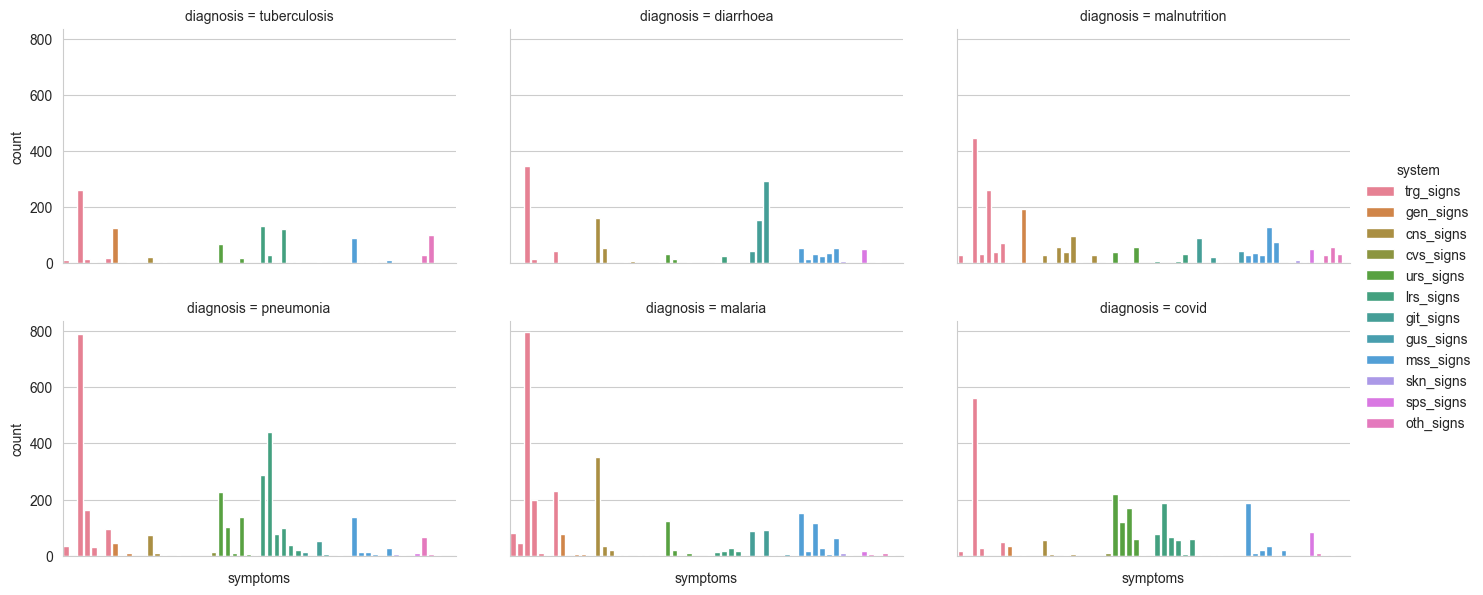

In [17]:
# Use catplot to plot the symptoms and diagnosis
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for top five diagnosis
top_six = df___.diagnosis.value_counts().head(6).index.tolist()
df___ = df___.loc[df___.diagnosis.isin(top_six)]

# Plot
g = sns.catplot(x="symptoms", hue="system", col="diagnosis", col_wrap=3,
                data=df___, kind="count", height=3, aspect=1.5)

g.set_xticklabels(rotation=90)

In [18]:
df[['duration', 'symptoms']][df[['duration', 'symptoms']].symptoms == 'headache'].value_counts()

duration  symptoms
2.0       headache    348
3.0       headache    239
1.0       headache    160
7.0       headache    149
5.0       headache     88
4.0       headache     84
14.0      headache     44
8.0       headache      8
10.0      headache      8
30.0      headache      4
21.0      headache      3
6.0       headache      2
12.0      headache      1
15.0      headache      1
90.0      headache      1
3021.0    headache      1
Name: count, dtype: int64

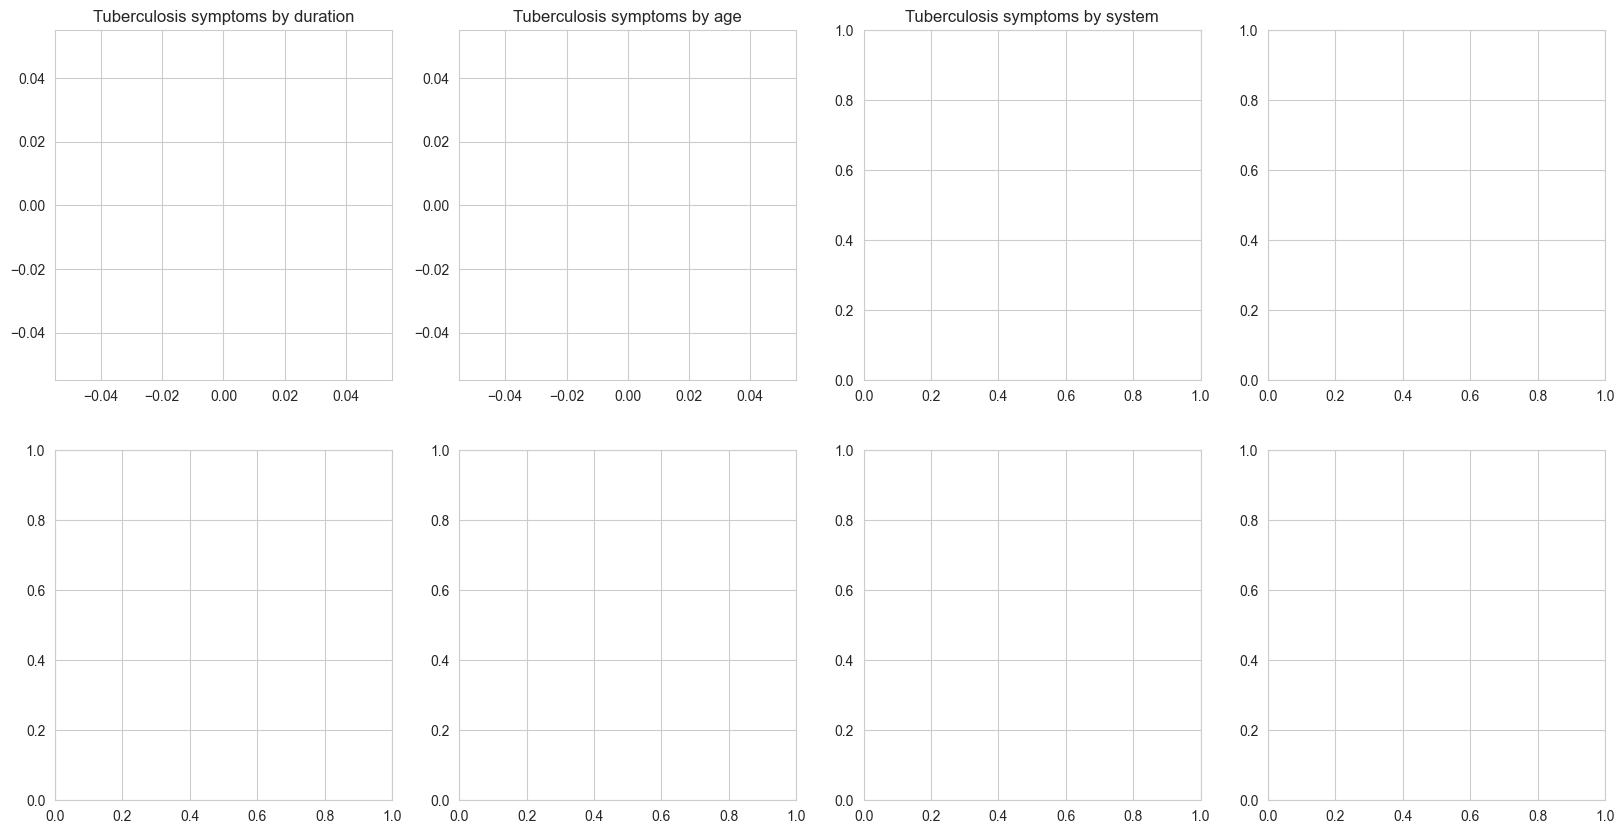

In [19]:
# plot tuberculosis symptoms
# plot 1. tuberculosis symptoms by duration
# plot 2. tuberculosis symptoms by age
# plot 3. tuberculosis symptoms by system
# plot 4. tuberculosis symptoms by sex
# plot 5. tuberculosis symptoms by bmi
# plot 6. tuberculosis symptoms by muac
# plot 7. tuberculosis symptoms by lab investigation
# plot 8. tuberculosis symptoms by type of tuberculosis

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(df[['duration', 'symptoms']][df[['duration', 'symptoms']].symptoms == 'tuberculosis'].duration, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Tuberculosis symptoms by duration')

sns.histplot(df[['age', 'symptoms']][df[['age', 'symptoms']].symptoms == 'tuberculosis'].age, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Tuberculosis symptoms by age')

sns.countplot(data=df[['system', 'symptoms']][df[['system', 'symptoms']].symptoms == 'tuberculosis'], x='system', ax=ax[0, 2])
ax[0, 2].set_title('Tuberculosis symptoms by system')

# sns.countplot(data=df[['system', 'symptoms']][df[['system', 'symptoms']].symptoms == 'tuberculosis'], x='sex', ax=ax[0, 3])
# ax[0, 3].set_title('Tuberculosis symptoms by sex')

# sns.histplot(df[['bmi', 'symptoms']][df[['bmi', 'symptoms']].symptoms == 'tuberculosis'].bmi, kde=True, ax=ax[1, 0])
# ax[1, 0].set_title('Tuberculosis symptoms by bmi')

# sns.countplot(df[['muac', 'symptoms']][df[['muac', 'symptoms']].symptoms == 'tuberculosis'], x='muac', ax=ax[1, 0])
# ax[1, 0].set_title('Tuberculosis symptoms by muac')
# 
# sns.countplot(data=df[['lab_investigation', 'symptoms']][df[['lab_investigation', 'symptoms']].symptoms == 'tuberculosis'], x='lab_investigation', ax=ax[1, 2])
# ax[1, 2].set_title('Tuberculosis symptoms by lab investigation')

# sns.countplot(data=df[['type_of_tuberculosis', 'symptoms']][df[['type_of_tuberculosis', 'symptoms']].symptoms == 'tuberculosis'], x='type_of_tuberculosis', ax=ax[1, 3])
# ax[1, 3].set_title('Tuberculosis symptoms by type of tuberculosis')

plt.show()